# This is a short introduction into the adiabatic-tides code

The main purpose of this code is to calculate the analytical solution to a dark matter halo that is exposed to a slowly increasing tidal field. 

In the following image you can see on the left the potential landscape of an NFW profile without any tidal field. In the center you can see an NFW halo that was exposed to a typical anisotropic tidal field. The halo has lost a lot of particles, since most particles with energies above the saddle-point energy can escape -- and additional particles escape since the self-gravity of the halo got weaker due to the mass-loss. In the right panel you can see an NFW that was exposed to an isotropic tidal field with the same largest eigenvalue. The result is very similar to the (more realistic) anisotropic case, since both cases get roughly truncated at the same energy level. The isotropic case in the right panel can be calculated analytically and this is what the adiabatic-tides code does!

For more explanation, please read the paper!

<img src="../../img/tidal_experiment_black.png" alt="drawing" width="800"/>

# Overview over this tutorial:

1. How to set up a base profile
2. How to create the adiabatically tidally truncated profiles
3. How to create grids of profiles and interpolate them

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os

import numpy as np
sys.path.append("../..")
import adiabatic_tides as at
from scipy.optimize import curve_fit

h5cache = "../../caches/halo_grid.hdf5"

# How to set up a base profile
All profiles are derived from ```adiabatic_tides.profiles.RadialProfile```. This class contains most of the functionality (which is independent of the concrete profile). If you want to create your own profile, derive it from this class. You can simply look at the code of ```adiabatic_tides.profiles.NFWProfile``` or ```adiabatic_tides.profiles.PowerlawProfile``` to get an idea how to do that.

In [2]:
# How to set up an NFW profile with concentration 10 and virial mass m200c = 10^6 solar masses
# Note that this profile is not truncated at the virial radius!
nfw = at.profiles.NFWProfile(conc=6., m200c=1e12)
# How to set up a Powerlaw profile
powerlaw = at.profiles.PowerlawProfile(slope=-1., rhoc=nfw.rhoc, rscale=nfw.rs)

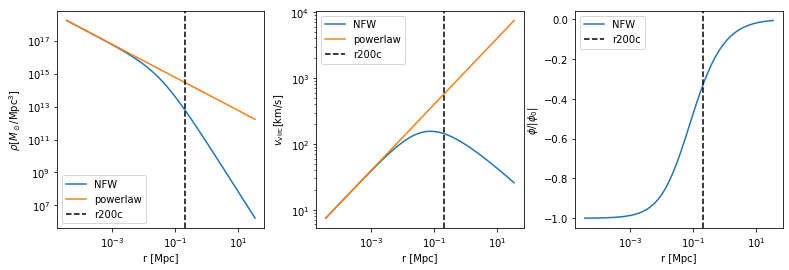

In [3]:
# Here some examples of what you can do with a profile
# Note that the default units are masses in Msol, lengths in Mpc and velocities in km/s
r = np.logspace(-3, 3) * nfw.rs

fig, axs = plt.subplots(1,3, figsize=(13,4))
fig.subplots_adjust(wspace=0.25)
axs[0].loglog(r, nfw.density(r), label="NFW")
axs[0].loglog(r, powerlaw.density(r), label="powerlaw")
axs[0].set_ylabel(r"$\rho [M_\odot / $Mpc$^3]$")

axs[1].loglog(r, nfw.vcirc(r), label="NFW")
axs[1].loglog(r, powerlaw.vcirc(r), label="powerlaw")
axs[1].set_ylabel(r"$v_{\rm{virc}} [$km/s$]$")

axs[2].semilogx(r, nfw.potential(r) / np.abs(nfw.phi0), label="NFW")
axs[2].set_ylabel(r"$\phi / |\phi_0|$")


for ax in axs:
    ax.set_xlabel(r"r [Mpc]")
    ax.axvline(nfw.r200c, label="r200c", color="black", linestyle="dashed")
    ax.legend()

# How to create a adiabatically tidally truncated profile
## First for a single iteration
Here we just do one adiabatic iteration. You can imagine that this means removing all mass that is unbound in the combination of NFW + Tidal field potential

Note that it is important to use the functions ```self_density``` and ```self_vcirc```, since the functions ```density``` and ```vcirc``` also consider the effect of the tidal field, which is important for the calculations, but usually not what you will be interested in as an output

In [4]:
prof_ad_1lvir = at.profiles.AdiabaticProfile(nfw, tidfac_rvir=1., niter=1, verbose=1)
prof_ad_4lvir = at.profiles.AdiabaticProfile(nfw, tidfac_rvir=4., niter=1, verbose=1)

i=1, mfrac=0.535364, dt=5.4s
i=1, mfrac=0.271737, dt=2.1s


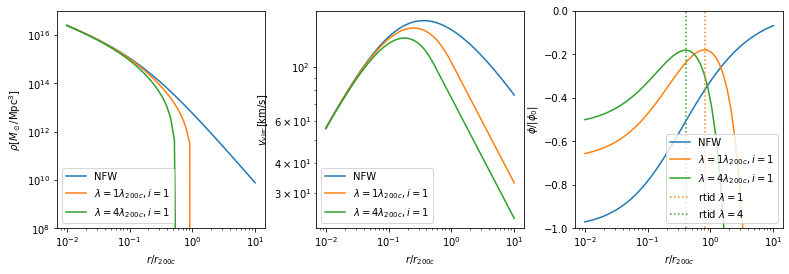

In [5]:
# Here some examples of what you can do with a profile
# Note that the default units are masses in Msol, lengths in Mpc and velocities in km/s
r = np.logspace(-2, 1) * nfw.r200c

fig, axs = plt.subplots(1,3, figsize=(13,4))
fig.subplots_adjust(wspace=0.25)
axs[0].loglog(r / nfw.r200c, nfw.density(r), label="NFW")
axs[0].loglog(r / nfw.r200c, prof_ad_1lvir.self_density(r), label=r"$\lambda=1 \lambda_{200c}, i=1$")
axs[0].loglog(r / nfw.r200c, prof_ad_4lvir.self_density(r), label=r"$\lambda=4 \lambda_{200c}, i=1$")
axs[0].set_ylim(1e8, 1e17)
axs[0].set_ylabel(r"$\rho [M_\odot / $Mpc$^3]$")

axs[1].loglog(r / nfw.r200c, nfw.vcirc(r), label="NFW")
axs[1].loglog(r / nfw.r200c, prof_ad_1lvir.self_vcirc(r), label=r"$\lambda=1 \lambda_{200c}, i=1$")
axs[1].loglog(r / nfw.r200c, prof_ad_4lvir.self_vcirc(r), label=r"$\lambda=4 \lambda_{200c}, i=1$")
axs[1].set_ylabel(r"$v_{\rm{virc}} [$km/s$]$")

axs[2].semilogx(r / nfw.r200c, nfw.potential(r) / np.abs(nfw.phi0), label="NFW")
axs[2].semilogx(r / nfw.r200c, prof_ad_1lvir.potential(r) / np.abs(nfw.phi0), label=r"$\lambda =1 \lambda_{200c}, i=1$")
axs[2].semilogx(r / nfw.r200c, prof_ad_4lvir.potential(r) / np.abs(nfw.phi0), label=r"$\lambda =4 \lambda_{200c}, i=1$")
axs[2].set_ylabel(r"$\phi / |\phi_0|$")
axs[2].set_ylim(-1.,0)

axs[2].axvline(prof_ad_1lvir._rtid / nfw.r200c, label="rtid $\lambda=1$", linestyle="dotted", color="C1")
axs[2].axvline(prof_ad_4lvir._rtid / nfw.r200c, label="rtid $\lambda=4$", linestyle="dotted", color="C2")

for ax in axs:
    ax.set_xlabel(r"$r / r_{200c}$")
    ax.legend()

# Now for many iterations

### Note how this takes a while:

In [6]:
prof_ad_1lvir = at.profiles.AdiabaticProfile(nfw, tidfac_rvir=1., niter=5, verbose=1, h5cache="../../caches/introduction.hdf5")

i=1, mfrac=0.535364, dt=2.2s
i=2, mfrac=0.395151, dt=2.1s
i=3, mfrac=0.332459, dt=2.1s
i=4, mfrac=0.296515, dt=2.1s
i=5, mfrac=0.273492, dt=2.1s
Caching result of calculation to ../../caches/introduction.hdf5 (i=5)


### That's why we have the option to add a hdf5-cache, so that the next time you calculate the same profile with the same tidal field, you don't have to wait that long:

In [7]:
prof_ad_1lvir = at.profiles.AdiabaticProfile(nfw, tidfac_rvir=1., niter=5, verbose=1, h5cache="../../caches/introduction.hdf5")

Reading result of previous calculation from ../../caches/introduction.hdf5 (i=5)


### If you change any parameters of your calculation a new calculation will be made automatically and added and added into the cachefile:

In [8]:
nfw2 = at.profiles.NFWProfile(conc=20., m200c=1e6)
prof_ad_1lvir = at.profiles.AdiabaticProfile(nfw2, tidfac_rvir=1., niter=5, verbose=1, h5cache="../../caches/introduction.hdf5")

No previous results found under ../../caches/introduction.hdf5
i=1, mfrac=0.687689, dt=6.7s
i=2, mfrac=0.615734, dt=2.6s
i=3, mfrac=0.590742, dt=2.7s
i=4, mfrac=0.580273, dt=2.7s
i=5, mfrac=0.57553, dt=2.6s
Caching result of calculation to ../../caches/introduction.hdf5 (i=5)


### For the rest of the tutorial we will just use already pre-calculated results, but if you want to recalculate them yourself, just delete the corresponding cache files!

note that i=100 seems to be always enough iterations. However, the procedure can be converged at way lower numbers already!

In [9]:
nfw = at.profiles.NFWProfile(conc=6., m200c=1e12)
prof_ad_1lvir = at.profiles.AdiabaticProfile(nfw, tidfac_rvir=1., niter=100, verbose=1, h5cache = h5cache)
prof_ad_4lvir = at.profiles.AdiabaticProfile(nfw, tidfac_rvir=4., niter=100, verbose=1, h5cache = h5cache)

Reading result of previous calculation from ../../caches/halo_grid.hdf5 (i=100)
Reading result of previous calculation from ../../caches/halo_grid.hdf5 (i=100)


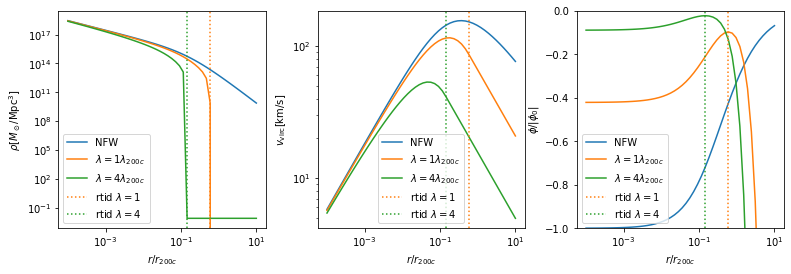

In [10]:
# Here some examples of what you can do with a profile
# Note that the default units are masses in Msol, lengths in Mpc and velocities in km/s
r = np.logspace(-4, 1) * nfw.r200c

fig, axs = plt.subplots(1,3, figsize=(13,4))
fig.subplots_adjust(wspace=0.25)
axs[0].loglog(r / nfw.r200c, nfw.density(r), label="NFW")
axs[0].loglog(r / nfw.r200c, prof_ad_1lvir.self_density(r), label=r"$\lambda=1 \lambda_{200c}$")
axs[0].loglog(r / nfw.r200c, prof_ad_4lvir.self_density(r), label=r"$\lambda=4 \lambda_{200c}$")

axs[0].set_ylabel(r"$\rho [M_\odot / $Mpc$^3]$")

axs[1].loglog(r / nfw.r200c, nfw.vcirc(r), label="NFW")
axs[1].loglog(r / nfw.r200c, prof_ad_1lvir.self_vcirc(r), label=r"$\lambda=1 \lambda_{200c}$")
axs[1].loglog(r / nfw.r200c, prof_ad_4lvir.self_vcirc(r), label=r"$\lambda=4 \lambda_{200c}$")
axs[1].set_ylabel(r"$v_{\rm{virc}} [$km/s$]$")

axs[2].semilogx(r / nfw.r200c, nfw.potential(r) / np.abs(nfw.phi0), label="NFW")
axs[2].semilogx(r / nfw.r200c, prof_ad_1lvir.potential(r) / np.abs(nfw.phi0), label=r"$\lambda=1 \lambda_{200c}$")
axs[2].semilogx(r / nfw.r200c, prof_ad_4lvir.potential(r) / np.abs(nfw.phi0), label=r"$\lambda=4 \lambda_{200c}$")
axs[2].set_ylabel(r"$\phi / |\phi_0|$")
axs[2].set_ylim(-1.,0)

for ax in axs:
    ax.axvline(prof_ad_1lvir._rtid / nfw.r200c, label="rtid $\lambda=1$", linestyle="dotted", color="C1")
    ax.axvline(prof_ad_4lvir._rtid / nfw.r200c, label="rtid $\lambda=4$", linestyle="dotted", color="C2")

    ax.set_xlabel(r"$r / r_{200c}$")
    
    ax.legend()

# Interpolating a grid of omdels

It can be useful to evaluate not each situation individually, but to create a grid of models in $\lambda/\lambda_s$. Here an example how to do that. For mor examples, see also

* notebooks/paper/subhalo_massloss.ipynb
* notebooks/paper/predictions_1d.ipynb

In [11]:
niter = 100
ls = np.logspace(-4, 2, 61)

mfrac = []
mfracvir = []

for i, l in enumerate(ls):
    nfw = at.profiles.NFWProfile(conc=10., m200c=1e6)
    prof_ad = at.profiles.AdiabaticProfile(nfw, tidfac_rs=l, niter=niter, h5cache=h5cache)
    mfrac.append(prof_ad.self_m_of_r(prof_ad._rtid) / nfw.m_of_r(nfw.rs))

# Here we set up some interpolation functions to evaluate subhaloes at arbitrary values of lambda/lambda_s
def get_msfrac(lsev, mode="all"):
    if mode == "all":
        return 10.**np.interp(np.log10(lsev), np.log10(ls),  np.log10(mfrac))
    else:
        return 10.**np.interp(np.log10(lsev), np.log10(ls),  np.log10(mfracvir))

def get_mvirfrac(conc, lvir, mode="all"):
    nfw = at.profiles.NFWProfile(conc=10., m200c=1e6) # Don't get confused, this concentration does not matter
    mvir_in_ms = nfw.m_of_r(conc*nfw.rs) / nfw.m_of_r(nfw.rs)
    lvir_in_ls = np.abs((nfw.accr(conc*nfw.rs) / (conc*nfw.rs)) / (nfw.accr(nfw.rs) / nfw.rs))

    l_in_ls = lvir * lvir_in_ls
    msfrac = get_msfrac(l_in_ls, mode=mode)

    return msfrac / mvir_in_ms

# A real-world example

Let's assume we had two subhaloes with concentrations $c=15$ and  $c=20$ orbiting with a given peri-center $r_p$ inside an NFW host with mass $M_{200c} = 10^{12} M_\odot$ and concentration $c=6$

How much mass would still be bound after a very long time (in the adiabatic limit) in dependence of the peri-center radius $r_p$?

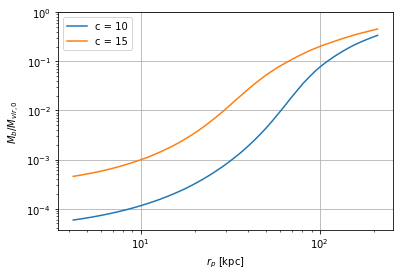

In [12]:
nfw_host = at.profiles.NFWProfile(conc=6., m200c=1e12)

for c in 10, 15:
    nfw_sub = at.profiles.NFWProfile(conc=c, m200c=1e6)

    rp = np.logspace(-1.7, 0) * nfw_host.r200c

    lam = nfw_host.tidal_eigval(rp)[0] # The value of the tidal field at rp (more precisely: only the radial eigenvalue)
    # convert to units of lambda_s
    lambda_s = np.abs(nfw_sub.accr(nfw_sub.rs)) / nfw_sub.rs
    lam_eff = lam / lambda_s

    # Use ms(lambda_eff) interpolator
    Mb_in_Ms = get_msfrac(lam_eff)

    # Convert mass fraction to units of Mvir
    Mb_in_Mvir = Mb_in_Ms / nfw_sub.m_of_r(nfw_sub.r200c) * nfw_sub.m_of_r(nfw_sub.rs)

    plt.loglog(rp * 1e3, Mb_in_Mvir, label="c = %d" % c)
    
plt.xlabel(r"$r_p$ [kpc]")
plt.ylabel(r"$M_b / M_{vir,0}$")
plt.ylim(None,1)
plt.grid()
plt.legend()

# What now?

Maybe have a look at
* notebooks/paper/predictions_1d.ipynb
* notebooks/paper/subhalo_massloss.ipynb

for more examples of how to use this code.

Also you can just have a look at the different functions that you can find e.g. in
```
adiabatic_tides.profiles.RadialProfile
adiabatic_tides.profiles.AdiabaticProfile
```
Most of them are reasonably well documented!

In case of any problems or questions, feel free to mail me at jstuecker@dipc.org